In [1]:
import os
import sys

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.rcParams["figure.dpi"] = 100

In [2]:
savefig=True
output_dir = "../figs/review"

For reference the infection function is shown below. If the host is already infected, it will carry $nph$ genomes.

def infect_host(hh, vv, nph, p_k=0.1):
    """
    Infect a host with parasites from a vector

    A host is bitten by a vector causing `k` parasite
    genomes to be transferred to the host. On average
    ~1 genome is transferred, and ~half are replaced.


    Parameters
        hh: None or ndarray, shape (nph, nsnps)
            Either None, which indicates host is currently
            uninfected, or an array containing parasite genomes 
            for the host.
        vv: ndarray, shape (npv, nsnps)
            Array containing parasite genomes for single vector.
        p_k: float
            Probability of transmission per parasite genome.
        recombination: bool
            Simulate recombination?

    Returns:
        new: ndarray, shape (npv, nsnps)
            Array containing new parasite genomes for host,
            after it has been bitten by `vv`.
    """

    k = np.max((1, np.random.binomial(len(vv), p_k)))  # number to transfer
    quantum = vv[np.random.choice(len(vv), k, replace=False)]  # which to transfer

    if hh is None:  # host is uninfected
        rel_wts = np.zeros(k)
        rel_wts[:] = 1.0 / k
        pool = quantum
    else:  # superinfection
        rel_wts = np.zeros(k + len(hh))
        rel_wts[:k] = 0.5 / k
        rel_wts[k:] = 0.5 / len(hh)
        pool = np.concatenate((quantum, hh), axis=0)

    new = pool[np.random.choice(len(pool), nph, replace=True, p=rel_wts)]
    return new

$$ Bin(n, p) = P_X(X=x;n,p) = \binom{n}{x} p^x (1 - p)^{n-x} $$

For the superinfection model...

$$ p = 0.5p_{allele} $$

... and $n = n_{ph}$

We want the probability that you *lose* an allele at a frequency $p_{allele}$ following super-infection. This is 

$$ P_X(X=0;n_{ph}, 0.5p_{allele}) = (1 - 0.5p_{allele})^{n_{ph}} $$

which is simply the probability that you *never* sample a compartment harbouring that allele.

In [3]:
def prob_lose_allele(pa, nph):
    """
    Return the probability that you lose an allele
    at an initial frequency of `pa` when super-infection
    occurs, given `nph` within-host sub-compartments
    
    """
    
    return (1 - 0.5 * pa) ** nph

In [4]:
pas = np.linspace(0, 1, 11)
nphs = [10, 20, 30]
cols = sns.color_palette("Set1", len(nphs))

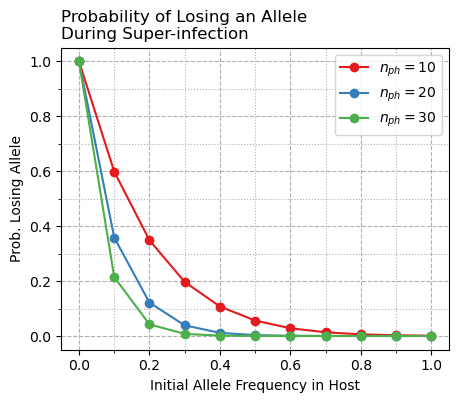

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

# Compute
for nph, col in zip(nphs, cols): 
    pls = prob_lose_allele(pas, nph)
    
    ax.plot(pas, pls, 'o-', c=col, label="$n_{ph}=$%d"%nph)

# Ticks
ax.xaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_minor_locator(plt.MultipleLocator(0.1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.yaxis.set_minor_locator(plt.MultipleLocator(0.1))
    
# Label
ax.legend()
ax.grid(which='major', ls='dashed')
ax.grid(which='minor', ls='dotted')
ax.set_xlabel("Initial Allele Frequency in Host")
ax.set_ylabel("Prob. Losing Allele")
ax.set_title("Probability of Losing an Allele\nDuring Super-infection", loc='left')

if savefig:
    fig.savefig(os.path.join(output_dir, "superinfection_theory.png"), bbox_inches="tight", pad_inches=0.5)

In [6]:
prob_lose_allele(pa=0.2, nph=10), prob_lose_allele(pa=0.2, nph=20)

(0.3486784401000001, 0.12157665459056935)

In [7]:
prob_lose_allele(pa=0.5, nph=10), prob_lose_allele(pa=0.5, nph=20)

(0.056313514709472656, 0.0031712119389339932)

### Confirm behaviour

In [8]:
def infect_host(hh, vv, nph, p_k=0.1):
    """
    Infect a host with parasites from a vector

    A host is bitten by a vector causing `k` parasite
    genomes to be transferred to the host. On average
    ~1 genome is transferred, and ~half are replaced.


    Parameters
        hh: None or ndarray, shape (nph, nsnps)
            Either None, which indicates host is currently
            uninfected, or an array containing parasite genomes 
            for the host.
        vv: ndarray, shape (npv, nsnps)
            Array containing parasite genomes for single vector.
        p_k: float
            Probability of transmission per parasite genome.
        recombination: bool
            Simulate recombination?

    Returns:
        new: ndarray, shape (npv, nsnps)
            Array containing new parasite genomes for host,
            after it has been bitten by `vv`.
    """

    k = np.max((1, np.random.binomial(len(vv), p_k)))  # number to transfer
    quantum = vv[np.random.choice(len(vv), k, replace=False)]  # which to transfer

    if hh is None:  # host is uninfected
        rel_wts = np.zeros(k)
        rel_wts[:] = 1.0 / k
        pool = quantum
    else:  # superinfection
        rel_wts = np.zeros(k + len(hh))
        rel_wts[:k] = 0.5 / k
        rel_wts[k:] = 0.5 / len(hh)
        pool = np.concatenate((quantum, hh), axis=0)

    new = pool[np.random.choice(len(pool), nph, replace=True, p=rel_wts)]
    return new

Text(0.0, 1.0, 'Probability of Losing an Allele\nDuring Super-infection')

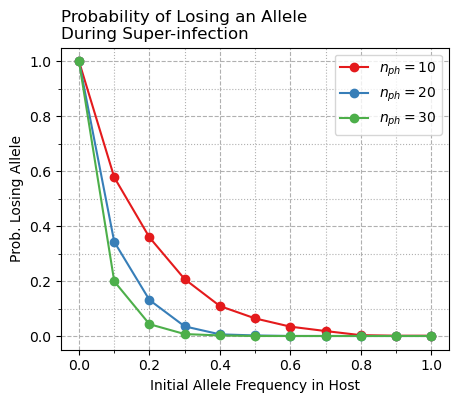

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

# Compute
obs = []
for nph, col in zip(nphs, cols):
    
    # Compute
    nreps = 10**3
    pas = np.linspace(0, 1, 11)

    results = np.zeros((len(pas), nreps))

    for i, p in enumerate(pas):
        for j in range(nreps):
            
            # Reset the host, vector, and infection
            hh = np.zeros(nph)
            vv = np.zeros(nph)
            p_k=0.2
            n = int(p * nph)
            hh[:n] = 1
            
            # Run superinfection
            r = infect_host(hh, vv, nph, p_k)
            
            # Store
            results[i, j] = sum(r) == 0  # allele has been lost
    
    # Get the equivalent results
    obs_pls = results.mean(1)

    ax.plot(pas, obs_pls, 'o-', c=col, label="$n_{ph}=$%d"%nph)
    
    
    obs.append(obs_pls)

# Ticks
ax.xaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_minor_locator(plt.MultipleLocator(0.1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.yaxis.set_minor_locator(plt.MultipleLocator(0.1))
    
# Label
ax.legend()
ax.grid(which='major', ls='dashed')
ax.grid(which='minor', ls='dotted')
ax.set_xlabel("Initial Allele Frequency in Host")
ax.set_ylabel("Prob. Losing Allele")
ax.set_title("Probability of Losing an Allele\nDuring Super-infection", loc='left')

- The function behaves as expected

### Comparison plot

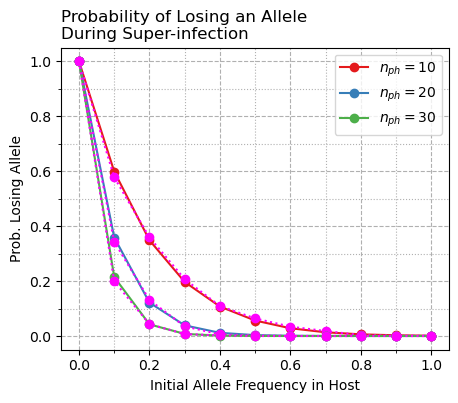

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

# Compute
for i, (nph, col) in enumerate(zip(nphs, cols)): 
    pls = prob_lose_allele(pas, nph)
    
    ax.plot(pas, pls, 'o-', c=col, label="$n_{ph}=$%d"%nph)
    ax.plot(pas, obs[i], 'o-', c='magenta', ls='dotted')

# Ticks
ax.xaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_minor_locator(plt.MultipleLocator(0.1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.yaxis.set_minor_locator(plt.MultipleLocator(0.1))
    
# Label
ax.legend()
ax.grid(which='major', ls='dashed')
ax.grid(which='minor', ls='dotted')
ax.set_xlabel("Initial Allele Frequency in Host")
ax.set_ylabel("Prob. Losing Allele")
ax.set_title("Probability of Losing an Allele\nDuring Super-infection", loc='left')

if savefig:
    fig.savefig(os.path.join(output_dir, "superinfection_empirical.png"), bbox_inches="tight", pad_inches=0.5)